In [172]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from scipy.ndimage import convolve
from tqdm import tqdm

class DBM_cube:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'height': N, 'width': N,'depth': N}
        else:
            self.dim = {'height': dimensions[0], 'width': dimensions[1],'depth': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  1 encodes fixed potential
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))
        self.fixed_grid[:, :, 0] = 1  # front boundary
        self.fixed_grid[:, :, -1] = 1  # back boundary
        self.fixed_grid[:, 0, :] = 1  # left boundary
        self.fixed_grid[:, -1, :] = 1  # right boundary
        self.fixed_grid[0, :, :] = 1  # top boundary
        self.fixed_grid[-1, :, :] = 1  # bottom boundary

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 0

        # To debug or not
        self.debug = debug
        self.display_interval = 75

        # Lightning distance to ground
        self.dist_to_ground = self.dim['height']

        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        self.difference_per_conv = []
        self.overall_sum = []

        # Neighborhood
        self.neighbors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), 
                         (-1, 0, 0), (0,-1, 0), (0, 0,-1)]
        
        self.initial_electric_pot()

        self.structure_neighbors.add((0, self.dim['width']//2, self.dim['depth']//2))
        self.update_electric_pot((0, self.dim['width']//2, self.dim['depth']//2))


    def display_state(self, this_grid=None, lightning=False):
        # Plot a figure displaying the environment
        if this_grid is None:
            this_grid = self.fixed_grid

        # If display lightning
        if lightning:
            # Display 0 potentials as yellow
            masked_arr = np.ma.masked_where(this_grid == 0, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='yellow')
        else:
            # Otherwise it's plotting potential
            # Otherwise set -1 as gray
            masked_arr = np.ma.masked_where(this_grid == -1, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='gray')

        # Display
        plt.figure(figsize=(16, 10))
        plt.imshow(masked_arr, cmap=cmap)
        plt.colorbar()

        if not lightning:
            plt.contour(this_grid, colors='white')
        plt.show()

    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.height, desc="How close the lightning is to the ground", unit="cells")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.height - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.height - self.newest_neighbor[0]
                    progress_bar.update(1)

    def check_struck_ground(self):
        # Look at all neighbors of newest neighbor
        for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            if self.newest_neighbor[0] > 5:
                # If within bounds
                if self.newest_neighbor[0]+dy > 0 and self.newest_neighbor[0]+dy < self.height and self.newest_neighbor[1]+dx > 0 and self.newest_neighbor[1]+dx < self.width:
                    # If one neighbor is ground (potential 1), break while loop
                    if self.grid[self.newest_neighbor[0]+dy, self.newest_neighbor[1]+dx] == 1:
                        self.struck_ground = True

    def update(self):

        # Debug
        if self.debug and self.steps % self.display_interval == 0:
            print("The lightning structure")
            self.display_state(lightning=True)

        
        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)



        # Raise each weight to the power of n
        # Ensure they sum up to 1
        #weights = np.array(weights)/np.sum(weights)
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.newest_neighbor = chosen_cell

        self.update_electric_pot(self.newest_neighbor)

        self.check_struck_ground()

        self.steps += 1

    def initial_electric_pot(self):

        # Create a linear gradient along the depth axis
        gradient = np.linspace(1/self.dim['height'], 1, self.dim['height'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient



    def update_electric_pot(self, pos):
        '''
        Calculates the unknown electric potential in the air
        by estimating the discrete solution to the 2D laplace
        equation (∇^2f = 0), which corresponds to the partial
        second derivatives being 0 everywhere. Intuitively it
        means that the electric potential changes smoothly everywhere.

        This is approximated by repeating diffusion over the grid,
        using a von Neumann kernel.
        '''

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = 1

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_delta in self.neighbors:
            neighbor_pos = (pos[0] + neighbor_delta[0], pos[1] + neighbor_delta[1], pos[2] + neighbor_delta[2])
            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        # Update the rest of the potential
        self.potential = self.iterative_diffusion()


    def iterative_diffusion(self):
        
        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid == 1

        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        while True:
            neighbor_avgs = np.zeros_like(new_potential)
            for dim in range(3):
                neighbor_avgs += np.roll(new_potential, shift=1, axis=dim)
                neighbor_avgs += np.roll(new_potential, shift=-1, axis=dim)
            neighbor_avgs /= 6  # Divided by the number of neighbors   

            new_potential = neighbor_avgs
                        
            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]

            self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
            self.overall_sum.append(np.sum(np.array(new_potential)))


            #print("old")
            #print(old_neighbors_avg)
            #print("new")
            #print(new_neighbors_avg)
            #print("difference")
            #print(abs(np.array(new_neighbors_avg) - np.array(old_neighbors_avg)))
            print("max of difference")
            print(np.max(abs(np.array(new_potential) - np.array(old_potential))))
            print()


            if np.max(abs(np.array(new_potential) - np.array(old_potential))) < self.threshold:
                break

            old_potential = np.copy(new_potential)

        if self.steps % self.display_interval == 0 and self.debug:
            print("The diffusion")
            self.display_state(self.potential)
        
        return new_potential

In [174]:
rnd.seed(10)
sim_instance = DBM_cube(N=5, nu=1.5, threshold=0.001)
#print(sim_instance.fixed_grid)
print(sim_instance.potential)
print("---")
for _ in range(3):
    sim_instance.update()
    print(sim_instance.fixed_grid)
    print(sim_instance.potential)

max of difference
0.03333333333333338

max of difference
0.005555555555555647

max of difference
0.00462962962962965

max of difference
0.002160493827160548

max of difference
0.0014917695473251058

max of difference
0.0010459533607681815

max of difference
0.0006144261545495966

[[[0.2        0.2        0.2        0.2        0.2       ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.2        0.2        0.         0.2        0.2       ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.2        0.2        0.2        0.2        0.2       ]]

 [[0.4        0.4        0.4        0.4        0.4       ]
  [0.4        0.3971222  0.39208676 0.3971222  0.4       ]
  [0.4        0.39208676 0.35993084 0.39208676 0.4       ]
  [0.4        0.3971222  0.39208676 0.3971222  0.4       ]
  [0.4        0.4        0.4        0.4        0.4       ]]

 [[0.6        0.6        0.6        0.6        0.6       ]
  [0.6        0.59855967 0.59659922 0.59855967 0.6       ]
  [0.6 

C:\Users\gabri\AppData\Local\Temp/ipykernel_21256/3148733263.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


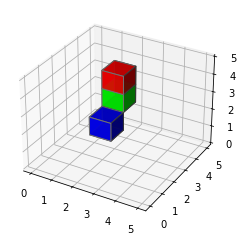

In [197]:
# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Create axis
axes = [5, 5, 5]

# Create Data
data = np.zeros(axes, dtype=bool)

data[2,2,4] = 1
data[2,2,3] = 1
data[2,1,2] = 1

# Control Transparency
alpha = 0.9

# Control colour
colors = np.empty(axes + [4], dtype=np.float32)
#print(colors)
colors[2,2,4] = [1, 0, 0, alpha]
colors[2,2,3] = [0, 1, 0, alpha]
colors[2,1,2] = [0, 0, 1, alpha]

#colors[0] = [1, 0, 0, alpha] # red
#colors[1] = [0, 1, 0, alpha] # green
#colors[2] = [0, 0, 1, alpha] # blue
#colors[3] = [1, 1, 0, alpha] # yellow
#colors[4] = [1, 1, 1, alpha] # grey

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Voxels is used to customizations of
# the sizes, positions and colors.
ax.voxels(data, facecolors=colors, edgecolors='grey');
fig.show()


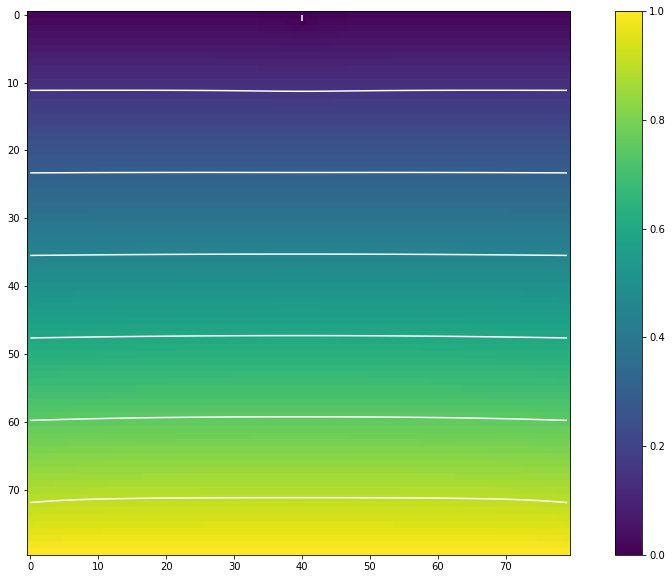

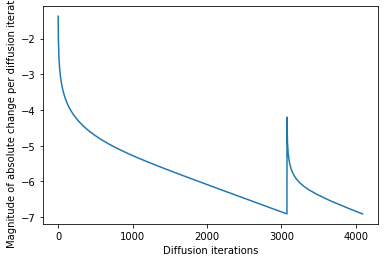

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.34it/s]


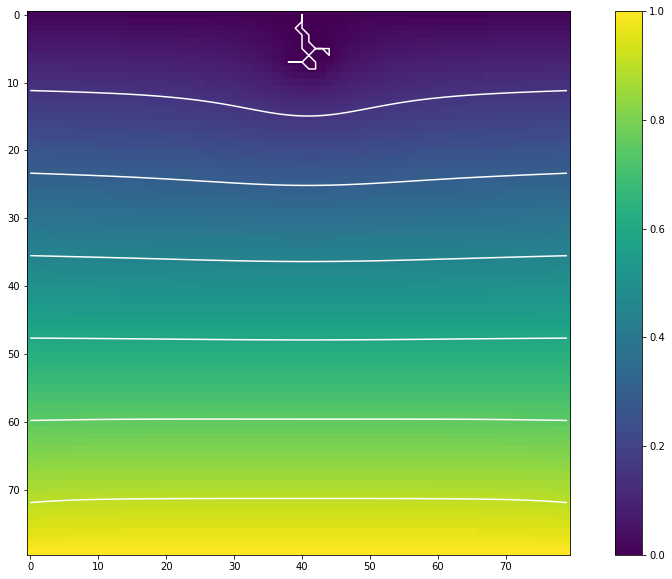

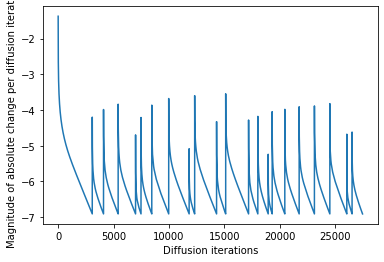

In [4]:
rnd.seed(10)
sim_instance = DBM_cube(width=80, height=80, n=1.5, threshold=0.001)

sim_instance.update()
sim_instance.display_state(sim_instance.potential)
plt.plot(np.log(sim_instance.difference_per_conv))
plt.xlabel("Diffusion iterations")
plt.ylabel("Magnitude of absolute change per diffusion iteration")
plt.show()

for _ in tqdm(range(20)):
  sim_instance.update()

sim_instance.display_state(sim_instance.potential)
plt.plot(np.log(sim_instance.difference_per_conv))
plt.xlabel("Diffusion iterations")
plt.ylabel("Magnitude of absolute change per diffusion iteration")

plt.show()

prev_difference_per_conv = sim_instance.difference_per_conv[:]